In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
from torchvision import datasets, transforms, models
import copy
import tqdm
from PIL import Image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


SELF EXPREIENCE:

RuntimeError: Found 0 files in subfolders of: /content/train
Supported extensions are: .jpg,.jpeg,.png,.ppm,.bmp,.pgm,.tif,.tiff,.webp

SOLUTION: Since PyTorch support loading image data from subfolders of data directory, we will have to put all cat images to cats folder and all dog images to dogs folder.

In [16]:
!mkdir train/cat
!mkdir train/dog

In [2]:
train_dir = "train"
train_dogs_dir = f'{train_dir}/dog'
train_cats_dir = f'{train_dir}/cat'
val_dir = "val"
val_dogs_dir = f'{val_dir}/dog'
val_cats_dir = f'{val_dir}/cat'
print("Printing train dir")
!ls {train_dir} | head -n 5 # Shows image files are in train folder
print("Printing train dog dir")
!ls {train_dogs_dir} | head -n 5 # Check the (empty) folder exist
print("Printing train cat dir")
!ls {train_cats_dir} | head -n 5 # Check the (empty) folder exist
print("Printing val dir")
!ls {val_dir} | head -n 5  # Shows subfolder dogs and cats exist
print("Printing val dog dir")
!ls {val_dogs_dir} | head -n 5 # Check the (empty) folder exist
print("Printing val cat dir")
!ls {val_cats_dir} | head -n 5 # Check the (empty) folder exist


Printing train dir
cat
dog
Printing train dog dir
dog.0.jpg
dog.1.jpg
dog.10.jpg
dog.100.jpg
dog.1000.jpg
ls: write error: Broken pipe
Printing train cat dir
cat.0.jpg
cat.1.jpg
cat.10.jpg
cat.100.jpg
cat.1000.jpg
ls: write error: Broken pipe
Printing val dir
cat
dog
Printing val dog dir
dog.5000.jpg
dog.5001.jpg
dog.5002.jpg
dog.5003.jpg
dog.5004.jpg
ls: write error: Broken pipe
Printing val cat dir
cat.5000.jpg
cat.5001.jpg
cat.5002.jpg
cat.5003.jpg
cat.5004.jpg
ls: write error: Broken pipe


In [10]:
import shutil
import re
files = os.listdir(train_dir)
# Move all train cat images to cats folder, dog images to dogs folder
for f in files:
    catSearchObj = re.search("cat", f)
    dogSearchObj = re.search("dog", f)
    if catSearchObj:
        shutil.move(f'{train_dir}/{f}', train_cats_dir)
    elif dogSearchObj:
        shutil.move(f'{train_dir}/{f}', train_dogs_dir)

In [11]:
print("Printing train dir") # shows cats, dogs subfolders only
!ls {train_dir} | head -n 5
print("Printing train dog dir") # there is now dog images in dogs folder
!ls {train_dogs_dir} | head -n 5
print("Printing train cat dir") # there is now cat images in cats folder
!ls {train_cats_dir} | head -n 5

Printing train dir
cat
dog
Printing train dog dir
dog.0.jpg
dog.1.jpg
dog.10.jpg
dog.100.jpg
dog.1000.jpg
ls: write error: Broken pipe
Printing train cat dir
cat.0.jpg
cat.1.jpg
cat.10.jpg
cat.100.jpg
cat.1000.jpg
ls: write error: Broken pipe


In [12]:
##total 25,000 images and 20 % for val dataset might be too much, therefore, 
##just take out 1,000 images for cats and dogs each
##dog
files = os.listdir(train_dogs_dir)
for f in files:
    validationDogsSearchObj = re.search("5\d\d\d", f)
    if validationDogsSearchObj:
        shutil.move(f'{train_dogs_dir}/{f}', val_dogs_dir)
print("Printing val dog dir")
!ls {val_dogs_dir} | head -n 5
##cat
files = os.listdir(train_cats_dir)
for f in files:
    validationCatsSearchObj = re.search("5\d\d\d", f)
    if validationCatsSearchObj:
        shutil.move(f'{train_cats_dir}/{f}', val_cats_dir)
print("Printing val cat dir")
!ls {val_cats_dir} | head -n 5

Printing val dog dir
dog.5000.jpg
dog.5001.jpg
dog.5002.jpg
dog.5003.jpg
dog.5004.jpg
ls: write error: Broken pipe
Printing val cat dir
cat.5000.jpg
cat.5001.jpg
cat.5002.jpg
cat.5003.jpg
cat.5004.jpg
ls: write error: Broken pipe


In [52]:
# Data augmentation and normalization for training
# Just normalization for validation
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.ImageFolder('train', transform=transform_train)
val_dataset = datasets.ImageFolder('val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 50, shuffle=False)

In [5]:
print(len(training_dataset))
print(len(val_dataset))
classes=training_dataset.classes
print(classes)

23000
2000
['cat', 'dog']


#THERE'S ANOTHER METHOD OF IMAGE VIEWING

https://medium.com/predict/using-pytorch-for-kaggles-famous-dogs-vs-cats-challenge-part-1-preprocessing-and-training-407017e1a10c

 def imshow(inp, title=None):
      """Imshow for Tensor."""
      inp = inp.numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      plt.imshow(inp)
      if title is not None:
          plt.title(title)
      plt.pause(0.001)  # pause a bit so that plots are updated
  # Get a batch of training data
  images, labels = next(iter(dataloaders['train']))
  # Make a grid from batch
  sample_train_images = torchvision.utils.make_grid(inputs)
  imshow(sample_train_images, title=classes)


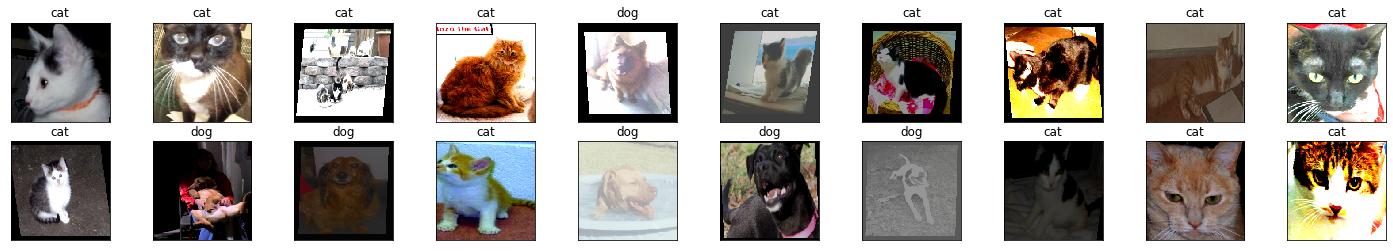

In [62]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

images, labels = next(iter(training_loader))
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [6]:
from torchvision import models
model = models.vgg16(pretrained=True, progress=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
for param in model.features.parameters():
  param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default

n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model.classifier[6].out_features)


2


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)


In [24]:
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in val_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(val_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(val_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
    torch.save(model.state_dict(), 'model.pt')


epoch : 1
training loss: 0.0046, acc 0.8863 
validation loss: 0.0009, validation acc 0.9815 
epoch : 2
training loss: 0.0041, acc 0.8997 
validation loss: 0.0011, validation acc 0.9795 
epoch : 3
training loss: 0.0039, acc 0.9057 
validation loss: 0.0008, validation acc 0.9845 
epoch : 4
training loss: 0.0037, acc 0.9109 
validation loss: 0.0009, validation acc 0.9820 
epoch : 5
training loss: 0.0036, acc 0.9095 
validation loss: 0.0008, validation acc 0.9835 
epoch : 6
training loss: 0.0035, acc 0.9137 
validation loss: 0.0010, validation acc 0.9805 
epoch : 7
training loss: 0.0034, acc 0.9167 
validation loss: 0.0008, validation acc 0.9830 
epoch : 8
training loss: 0.0034, acc 0.9175 
validation loss: 0.0009, validation acc 0.9845 
epoch : 9
training loss: 0.0034, acc 0.9190 
validation loss: 0.0010, validation acc 0.9820 
epoch : 10
training loss: 0.0033, acc 0.9220 
validation loss: 0.0011, validation acc 0.9810 


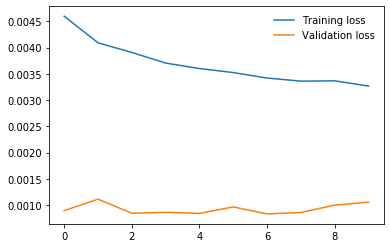

In [25]:
plt.plot(running_loss_history, label='Training loss')
plt.plot(val_running_loss_history, label='Validation loss')
plt.legend(frameon=False)

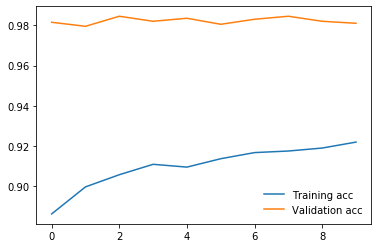

In [26]:
plt.plot(running_corrects_history, label='Training acc')
plt.plot(val_running_corrects_history, label='Validation acc')
plt.legend(frameon=False)

In [8]:
##load saved training model

model.load_state_dict(torch.load('model.pt'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
##load test dataset
test_dir='test'
test_files = [i for i in (os.path.join(test_dir, f) for f in os.listdir(test_dir)) if os.path.isfile(i)]
len(test_files)


12500

load test dataset method is according to 
https://github.com/wontheone1/cats-dogs-pytorch/blob/master/catsanddogs.ipynb

In [14]:
def apply_test_transforms(inp):
    out = transforms.functional.resize(inp, [224,224])
    out = transforms.functional.to_tensor(out)
    out = transforms.functional.normalize(out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return out

In [19]:
im_as_tensor = apply_test_transforms(im)
print(im_as_tensor.size()) # torch.Size([3, 224, 224])
minibatch = torch.stack([im_as_tensor])
print(minibatch.size()) # torch.Size([1, 3, 224, 224])

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


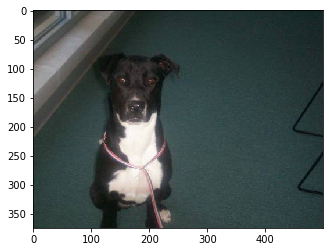

In [18]:
test_dir='test'
test_files = [i for i in (os.path.join(test_dir, f) for f in os.listdir(test_dir)) if os.path.isfile(i)]
im = Image.open(f'{test_files[0]}')
plt.imshow(im)

In [23]:
    x = minibatch.to(device)
    y = model(x)

In [24]:
print(y)

tensor([[-8.4591,  7.7473]], device='cuda:0', grad_fn=<AddmmBackward>)


In [26]:
softMax = nn.Softmax(dim = 1)
preds = softMax(model(minibatch.to(device)))

In [27]:
preds

tensor([[9.1547e-08, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [35]:
def predict_dog_prob_of_single_instance(model, tensor):
    batch = torch.stack([tensor])
    softMax = nn.Softmax(dim = 1)
    preds = softMax(model(batch.to(device)))
    return preds[0,1].item()

In [36]:
def test_data_from_fname(fname):
    im = Image.open(f'{fname}')
    return apply_test_transforms(im)

In [37]:
import re

def extract_file_id(fname):
    print("Extracting id from " + fname)
    return int(re.search('\d+', fname).group())

extract_file_id("cat34432.jpg")

Extracting id from cat34432.jpg


34432

In [38]:
model.eval()
id_to_dog_prob = {extract_file_id(fname): 
                  predict_dog_prob_of_single_instance(model,
                                                      test_data_from_fname(fname))
                  for fname in test_files}

Extracting id from test/5484.jpg
Extracting id from test/1839.jpg
Extracting id from test/3113.jpg
Extracting id from test/4836.jpg
Extracting id from test/3510.jpg
Extracting id from test/6521.jpg
Extracting id from test/10710.jpg
Extracting id from test/8506.jpg
Extracting id from test/5716.jpg
Extracting id from test/12253.jpg
Extracting id from test/2670.jpg
Extracting id from test/3002.jpg
Extracting id from test/756.jpg
Extracting id from test/8654.jpg
Extracting id from test/1133.jpg
Extracting id from test/2004.jpg
Extracting id from test/930.jpg
Extracting id from test/5896.jpg
Extracting id from test/886.jpg
Extracting id from test/9851.jpg
Extracting id from test/8688.jpg
Extracting id from test/8692.jpg
Extracting id from test/9689.jpg
Extracting id from test/8145.jpg
Extracting id from test/7885.jpg
Extracting id from test/11613.jpg
Extracting id from test/10101.jpg
Extracting id from test/4178.jpg
Extracting id from test/9136.jpg
Extracting id from test/8240.jpg
Extractin

In [45]:
import pandas as pd
pd.set_option('display.float_format',lambda x : '%f' % x)

ds = pd.Series({id : label for (id, label) in zip(id_to_dog_prob.keys(), id_to_dog_prob.values())})
ds.head()

5484   1.000000
1839   0.000000
3113   0.000000
4836   1.000000
3510   0.000000
dtype: float64

In [46]:

df = pd.DataFrame(ds, columns = ['label']).sort_index()
df['id'] = df.index
df = df[['id', 'label']]
df.head()

,id,label
1,1,1.000000
2,2,1.000000
3,3,1.000000
4,4,1.000000
5,5,0.000000


In [48]:
df.to_csv('SUBMISSION_FILE.csv', index = False)


In [49]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('kaggle_Dogs_VS_Cats')

In [63]:

# get some random training images
dataiter = iter(training_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images(img_grid)
im_convert(img_grid, )
# write to tensorboard
writer.add_image('kaggle_Dogs_VS_Cats', img_grid)

In [ ]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.
TensorBoard 2.1.0 at http://pytorch-vsc:6006/ (Press CTRL+C to quit)
